# Functions that will work on the background

## Image Segmentation

### Get bounding boxes from image from user interaction

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from PIL import Image

In [2]:
rect_start = None
rect_end = None
drawing = False

In [3]:
def draw_rectangle(event, x, y, flags, param):
    """Mouse callback function to draw a rectangle."""
    global rect_start, rect_end, drawing

    if event == cv2.EVENT_LBUTTONDOWN:
        rect_start = (x, y)
        drawing = True

    elif event == cv2.EVENT_LBUTTONUP:
        rect_end = (x, y)
        drawing = False
        cv2.rectangle(img_display, rect_start, rect_end, (255, 0, 0), 4)
        cv2.imshow("Draw Rectangle", img_display)

In [4]:
def interactive_bbox_selection(image_path, window_width=800, window_height=800):
    """Allows the user to draw a rectangle and converts to Ultralytics BBox format."""
    global img_display
    
    # Load image
    img = cv2.imread(image_path)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_display = img.copy()

    cv2.namedWindow("Draw Rectangle", cv2.WINDOW_NORMAL)
    cv2.resizeWindow("Draw Rectangle", window_width, window_height)  # Resize window

    # Set mouse callback
    cv2.setMouseCallback("Draw Rectangle", draw_rectangle)

    while True:
        cv2.imshow("Draw Rectangle", img_display)
        key = cv2.waitKey(1) & 0xFF
        if key == 13:  # Press 'Enter' to finish
            break

    cv2.destroyAllWindows()

    # Convert to Ultralytics BBox format (normalized)
    if rect_start and rect_end:
        x1, y1 = rect_start
        x2, y2 = rect_end

        # Ensure coordinates are sorted properly
        x_min, y_min = min(x1, x2), min(y1, y2)
        x_max, y_max = max(x1, x2), max(y1, y2)

        # Convert to Ultralytics normalized BBox format
        coord = [
            x_min,
            y_min,
            x_max,
            y_max
        ]
        
        print("Coordinates:", coord)
        return coord
    else:
        print("No rectangle was drawn.")
        return None

In [ ]:
coord = interactive_bbox_selection("frames/frame_0000.png")

### Segment image based on rectangle coordinates

In [ ]:
from ultralytics import SAM
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

source = "test_image.jpg"

model = SAM("sam_l.pt")

results = model(source,
                device="cpu",
                retina_masks=True,
                imgsz=640,
                conf=0.2,
                iou=0.4,
                bboxes=[206, 259, 3293, 5996])

for result in results:
    img = np.copy(result.orig_img)

    for ci, c in enumerate(result):
        b_mask = np.zeros(img.shape[:2], np.uint8)

        # Create contour mask 
        contour = c.masks.xy.pop().astype(np.int32).reshape(-1, 1, 2)
        _ = cv2.drawContours(b_mask, [contour], -1, (255, 255, 255), cv2.FILLED)

        isolated = img.copy()
        isolated[b_mask == 0] = 0

        contour = contour.reshape(-1, 2)

        x_min, y_min = np.min(contour, axis=0)
        x_max, y_max = np.max(contour, axis=0)

        # Crop the image to get only the segmented
        cropped_image = isolated[y_min:y_max, x_min:x_max]
        resultado_rgb = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)

        # Make the image square and centralize the segmented image
        height, width, _ = resultado_rgb.shape
        size = max(height, width)
        square_image = np.zeros((size, size, 3), dtype=np.uint8)

        # Calculate the top-left corner to centralize the image
        y_offset = (size - height) // 2
        x_offset = (size - width) // 2

        square_image[y_offset:y_offset + height, x_offset:x_offset + width] = resultado_rgb

        plt.imshow(square_image)

Making it a function

In [5]:
def segmenting_image(coordinates, model, source, device="cpu"):
    results = model(source,
                    device=device,
                    retina_masks=True,
                    imgsz=640,
                    bboxes=coordinates)
    
    for result in results:
        img = np.copy(result.orig_img)
        for ci, c in enumerate(result):
            b_mask = np.zeros(img.shape[:2], np.uint8)
            # Create contour mask 
            contour = c.masks.xy.pop().astype(np.int32).reshape(-1, 1, 2)
            cv2.drawContours(b_mask, [contour], -1, (255, 255, 255), cv2.FILLED)
            
            # Create an RGBA image with an alpha channel
            isolated = np.zeros((*img.shape[:2], 4), dtype=np.uint8)
            isolated[..., :3] = img
            isolated[b_mask == 0, 3] = 0  # Set alpha to 0 for background
            isolated[b_mask != 0, 3] = 255  # Set alpha to 255 for the segmented object
            
            contour = contour.reshape(-1, 2)
            x_min, y_min = np.min(contour, axis=0)
            x_max, y_max = np.max(contour, axis=0)
            
            # Crop the image to get only the segmented object
            cropped_image = isolated[y_min:y_max, x_min:x_max]
            
            # Create a square image with 4 channels (RGBA)
            height, width, _ = cropped_image.shape
            size = max(height, width)
            square_image = np.zeros((size, size, 4), dtype=np.uint8)
            
            # Calculate the top-left corner to centralize the image
            y_offset = (size - height) // 2
            x_offset = (size - width) // 2
            
            # Copy the cropped image into the square image
            square_image[y_offset:y_offset + height, x_offset:x_offset + width] = cropped_image
            
            # Save the image with 4 channels (RGBA)
            cv2.imwrite("segmented.png", square_image)
            
            # For display, convert to RGB for matplotlib
            plt.imshow(cv2.cvtColor(square_image, cv2.COLOR_RGBA2BGRA))
            plt.axis('off')
            plt.show()

### Combining everything

100%|██████████| 38.8M/38.8M [00:00<00:00, 55.5MB/s]


Coordinates: [595, 187, 2461, 3081]

image 1/1 c:\Users\gusta\Documents\Projetos Diversao\MiniAid\backgroundFunctions\images\IMG_20250506_193722.jpg: 640x640 1 0, 933.8ms
Speed: 25.1ms preprocess, 933.8ms inference, 216.3ms postprocess per image at shape (1, 3, 640, 640)


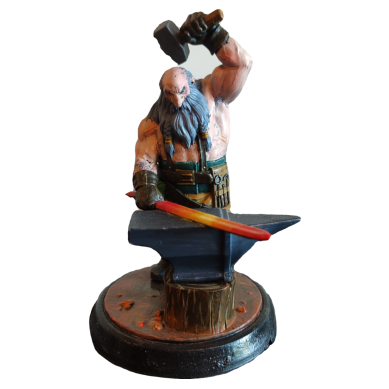

In [6]:
from ultralytics import SAM
%matplotlib inline
import torch

rect_start = None
rect_end = None
drawing = False

source = "images/IMG_20250506_193722.jpg"
model = SAM("models/mobile_sam.pt")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

coordinates = interactive_bbox_selection(source)
segmenting_image(coordinates, model, source, device)

### Training Segmentation Model

#### Loading Model

In [1]:
from ultralytics import YOLO
import torch

model = YOLO("models/yolo11s-seg.pt")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


#### Training

In [2]:
results = model.train(data      =   "Miniatures/data.yaml",
                      epochs    =   250,
                      imgsz     =   640,
                      patience  =   10,
                      batch     =   16,
                      device    =   device,
                      max_det   =   1)

engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=Miniatures/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=250, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=1, mixup=0.0, mode=train, model=models/yolo11s-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=False, project=None, rect=False, resume=False, retina_masks=False, 

### Exporting Model

In [17]:
from ultralytics import YOLO

# Load a model
model = YOLO("models/segmentation_model.pt")  # load a custom trained model

# Export the model
model.export(format="onnx")

Ultralytics 8.3.82  Python-3.10.11 torch-2.6.0+cpu CPU (Intel Core(TM) i7-9850H 2.60GHz)
YOLO11s-seg summary (fused): 113 layers, 10,067,203 parameters, 0 gradients, 35.3 GFLOPs

PyTorch: starting from 'models\segmentation_model.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) ((1, 37, 8400), (1, 32, 160, 160)) (19.6 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0', 'onnxslim'] not found, attempting AutoUpdate...
   ---------------------------------------- 16.5/16.5 MB 51.7 MB/s eta 0:00:00
   ---------------------------------------- 6.3/6.3 MB 64.2 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.1
    Uninstalling sympy-1.13.1:
      Successfully uninstalled sympy-1.13.1

requirements: AutoUpdate success  58.7s, installed 2 packages: ['onnx>=1.12.0', 'onnxslim']
requirements:  Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.19.0 opset 19...
ONNX: slimming with onnxslim 0.

'models\\segmentation_model.onnx'

## Black Point adjust

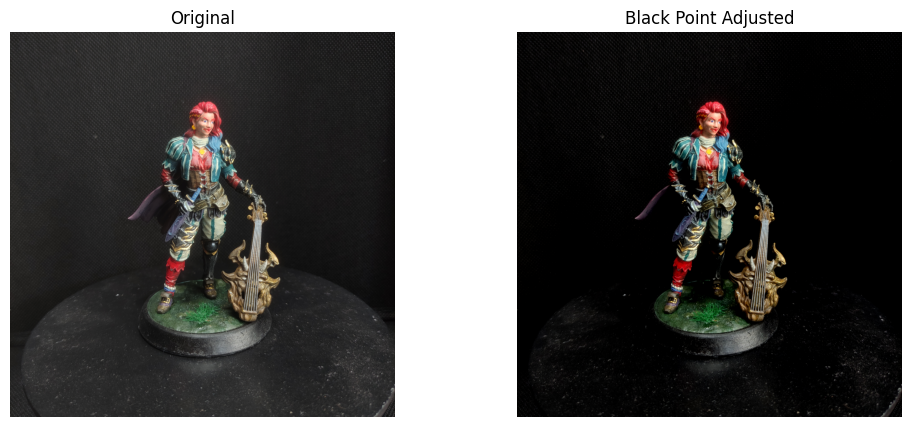

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def adjust_black_point(img, black_point=20):
    """
    Shift the black point of the image. 
    All pixel values below `black_point` are set to 0, 
    and the rest are scaled accordingly.

    Parameters:
        img (numpy.ndarray): Input image (uint8, 0–255).
        black_point (int): Black point threshold (0–255).

    Returns:
        numpy.ndarray: Black point adjusted image.
    """
    img = img.astype(np.float32)

    # Subtract black point
    img = np.clip(img - black_point, 0, 255 - black_point)

    # Rescale to full 0-255 range
    img = (img / (255 - black_point)) * 255
    img = np.clip(img, 0, 255).astype(np.uint8)

    return img

# Example usage
image = cv2.imread('target_dir/images/IMG_20250704_120703.jpg')  # BGR format
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

adjusted = adjust_black_point(image_rgb, black_point=40)

# Show original vs adjusted
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Original')
plt.imshow(image_rgb)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Black Point Adjusted')
plt.imshow(adjusted)
plt.axis('off')

plt.show()

## 3D reconstruction from videos

### Extracting frames

In [23]:
import cv2
import os
from tqdm import tqdm
import numpy as np

def extract_frames(video_path, output_folder="frames", fps=1):
    """
    Extract one frame per second from a video.

    Args:
        video_path (str): The path to the video to be extracted.
        output_folder (str): The path to save the extracted frames.
        fps (int): Number of frames to extract per second (default 1).

    Returns:
        Extracted frames will be saved in the output_folder in png format.
    """

    if not os.path.exists(output_folder):
        os.mkdir(output_folder)

    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    video_fps = cap.get(cv2.CAP_PROP_FPS)
    rotation = int(cap.get(cv2.CAP_PROP_ORIENTATION_META))  # This property is not always available

    print("------ Extracting frames ------")

    # Calculate the frame indices to extract (one per second)
    duration_sec = int(total_frames / video_fps)
    frame_indices = [int(i * video_fps) for i in range(duration_sec)]

    extracted_count = 0
    with tqdm(total=len(frame_indices), unit="frame") as pbar:
        for frame_idx in frame_indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
            ret, frame = cap.read()
            if not ret:
                print(f"Warning: Unable to read frame at index {frame_idx}")
                continue

            # Uncomment and handle rotation if needed
            if rotation == 90:
                frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
            elif rotation == 180:
                frame = cv2.rotate(frame, cv2.ROTATE_180)
            elif rotation == 270:
                frame = cv2.rotate(frame, cv2.ROTATE_90_COUNTERCLOCKWISE)

            frame_filename = os.path.join(output_folder, f"frame_{extracted_count:04d}.png")
            cv2.imwrite(frame_filename, frame)
            extracted_count += 1
            pbar.update(1)

    cap.release()

In [24]:
extract_frames(r"VID_20250928_154312.mp4", "frames", fps=1)

------ Extracting frames ------


100%|██████████| 23/23 [00:04<00:00,  5.27frame/s]


### Segmentation Trials

In [25]:
import os
import cv2
from ultralytics import YOLO

def segment_and_save_images(input_folder, output_folder, model_path, device="cpu", conf=0.5):
    """
    Runs YOLOv11s segmentation on all images in input_folder and saves segmented images to output_folder.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    model = YOLO(model_path)
    image_files = [f for f in os.listdir(input_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    for img_name in image_files:
        img_path = os.path.join(input_folder, img_name)
        results = model(img_path, device=device, conf=conf, retina_masks=True, max_det=1)
        for result in results:
            img = result.orig_img.copy()
            for c in result:
                mask = c.masks.data[0].cpu().numpy().astype('uint8') * 255
                mask = cv2.resize(mask, (img.shape[1], img.shape[0]))
                segmented = cv2.bitwise_and(img, img, mask=mask)
                out_path = os.path.join(output_folder, f"seg_{img_name}")
                cv2.imwrite(out_path, segmented)
                break  # Save only the first mask per image (remove if you want all)

# Example usage:
segment_and_save_images("frames", "target_dir/images", "models/segmentation_model.pt", device="cpu")


image 1/1 c:\Users\gusta\Documents\Projetos Diversao\MiniAid\frames\frame_0000.png: 640x384 1 miniature, 143.0ms
Speed: 2.5ms preprocess, 143.0ms inference, 10.3ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 c:\Users\gusta\Documents\Projetos Diversao\MiniAid\frames\frame_0001.png: 640x384 1 miniature, 134.7ms
Speed: 2.3ms preprocess, 134.7ms inference, 10.1ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 c:\Users\gusta\Documents\Projetos Diversao\MiniAid\frames\frame_0002.png: 640x384 1 miniature, 135.4ms
Speed: 2.3ms preprocess, 135.4ms inference, 9.6ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 c:\Users\gusta\Documents\Projetos Diversao\MiniAid\frames\frame_0003.png: 640x384 1 miniature, 135.5ms
Speed: 1.8ms preprocess, 135.5ms inference, 9.5ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 c:\Users\gusta\Documents\Projetos Diversao\MiniAid\frames\frame_0004.png: 640x384 1 miniature, 132.2ms
Speed: 1.9ms preprocess, 132.2ms inf

In [4]:
import os
import cv2
from ultralytics import YOLO

def create_binary_masks(input_folder, output_folder, model_path, device='cpu', conf=0.5):
    """
    Runs YOLOv11 segmentation on all images in input_folder and saves binary masks to output_folder.
    Each mask is a single-channel image with 255 for the segmented area and 0 elsewhere.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    model = YOLO(model_path)
    image_files = [f for f in os.listdir(input_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    for img_name in image_files:
        img_path = os.path.join(input_folder, img_name)
        results = model(img_path, device=device, conf=conf, retina_masks=True, max_det=1)
        for result in results:
            for c in result:
                mask = c.masks.data[0].cpu().numpy().astype('uint8') * 255
                mask = cv2.resize(mask, (result.orig_img.shape[1], result.orig_img.shape[0]))
                out_path = os.path.join(output_folder, f"mask_{img_name}")
                cv2.imwrite(out_path, mask)
                break  # Only save the first mask per image
            break  # Only process the first result per image

# Example usage:
create_binary_masks("frames", "masks", "models/segmentation_model.pt", device=device)


image 1/1 c:\Users\gusta\Documents\Projetos Diversao\MiniAid\frames\IMG_20250726_195134.jpg: 640x384 1 miniature, 228.2ms
Speed: 8.0ms preprocess, 228.2ms inference, 72.9ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 c:\Users\gusta\Documents\Projetos Diversao\MiniAid\frames\IMG_20250726_195143.jpg: 640x384 1 miniature, 140.5ms
Speed: 2.8ms preprocess, 140.5ms inference, 50.8ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 c:\Users\gusta\Documents\Projetos Diversao\MiniAid\frames\IMG_20250726_195154.jpg: 640x384 1 miniature, 134.3ms
Speed: 2.0ms preprocess, 134.3ms inference, 49.8ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 c:\Users\gusta\Documents\Projetos Diversao\MiniAid\frames\IMG_20250726_195203.jpg: 640x384 1 miniature, 139.6ms
Speed: 2.4ms preprocess, 139.6ms inference, 49.7ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 c:\Users\gusta\Documents\Projetos Diversao\MiniAid\frames\IMG_20250726_205723.jpg: 640x384 1 miniatur

### DUSt3R

In [1]:
import torch
from dust3r.cloud_opt import GlobalAlignerMode, global_aligner
from dust3r.image_pairs import make_pairs
from dust3r.inference import inference
from dust3r.model import AsymmetricCroCo3DStereo
from dust3r.utils.image import load_images

def runDUSt3R(device: str = "cuda", dir_path: str = "images"):
    batch_size = 1
    schedule = "cosine"
    lr = 0.01
    niter = 300
    model_name = "naver/DUSt3R_ViTLarge_BaseDecoder_512_dpt"
    model = AsymmetricCroCo3DStereo.from_pretrained(model_name).to(device)
    images = load_images(dir_path, size=512)
    pairs = make_pairs(images, scene_graph="complete", prefilter=None, symmetrize=True)
    output = inference(pairs, model, device, batch_size=batch_size)
    scene = global_aligner(
        output, device=device, mode=GlobalAlignerMode.PointCloudOptimizer
    )
    loss = scene.compute_global_alignment(
        init="mst", niter=niter, schedule=schedule, lr=lr
    )

    scene.show()

c:\Users\gnoceras\Documents\GustavoPersonal\MiniAid\backgroundFunctions\dust3r\cloud_opt\base_opt.py:275: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)


Warning, cannot find cuda-compiled version of RoPE2D, using a slow pytorch version instead


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_path = "images"

runDUSt3R(device=device, dir_path=base_path)

In [3]:
import open3d as o3d

cloud_path = "reconstruction.ply"
pcd = o3d.io.read_point_cloud(cloud_path)
pcd, ind = pcd.remove_statistical_outlier(nb_neighbors=50, std_ratio=1)
o3d.visualization.draw_geometries([pcd], window_name="Point Cloud")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [4]:
o3d.io.write_point_cloud("reconstructions/Uten.ply", pcd)

True

### VGG-T

In [1]:
import os
import torch
import numpy as np
import sys
import glob
import gc
import time

sys.path.append("vggt/")

from visual_util import predictions_to_glb
from vggt.models.vggt import VGGT
from vggt.utils.load_fn import load_and_preprocess_images
from vggt.utils.pose_enc import pose_encoding_to_extri_intri
from vggt.utils.geometry import unproject_depth_map_to_point_map

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
print("Initializing and loading VGGT model...")

model = VGGT()
_URL = "https://huggingface.co/facebook/VGGT-1B/resolve/main/model.pt"
model.load_state_dict(torch.hub.load_state_dict_from_url(_URL))

model.eval()
model = model.to(device)

Initializing and loading VGGT model...


In [3]:
def run_model(target_dir, model):
    """
    Run the VGGT model on images in the 'target_dir/images' folder and return predictions.
    """
    print(f"Processing images from {target_dir}")

    start_time = time.time()
    gc.collect()
    torch.cuda.empty_cache()

    # Device check
    device = "cuda" if torch.cuda.is_available() else "cpu"


    # Move model to device
    model = model.to(device)
    model.eval()

    # Load and preprocess images
    image_names = glob.glob(os.path.join(target_dir, "images", "*"))
    image_names = sorted(image_names)
    print(f"Found {len(image_names)} images")
    if len(image_names) == 0:
        raise ValueError("No images found. Check your upload.")

    images = load_and_preprocess_images(image_names).to(device)
    print(f"Preprocessed images shape: {images.shape}")

    # Run inference
    print("Running inference...")
    #dtype = torch.bfloat16 if torch.cuda.get_device_capability()[0] >= 8 else torch.float16

    with torch.no_grad():
        #with torch.cuda.amp.autocast(dtype=dtype):
        predictions = model(images)

    # Convert pose encoding to extrinsic and intrinsic matrices
    print("Converting pose encoding to extrinsic and intrinsic matrices...")
    extrinsic, intrinsic = pose_encoding_to_extri_intri(predictions["pose_enc"], images.shape[-2:])
    predictions["extrinsic"] = extrinsic
    predictions["intrinsic"] = intrinsic

    # Convert tensors to numpy
    for key in predictions.keys():
        if isinstance(predictions[key], torch.Tensor):
            predictions[key] = predictions[key].cpu().numpy().squeeze(0)  # remove batch dimension

    # Generate world points from depth map
    print("Computing world points from depth map...")
    depth_map = predictions["depth"]  # (S, H, W, 1)
    world_points = unproject_depth_map_to_point_map(depth_map, predictions["extrinsic"], predictions["intrinsic"])
    predictions["world_points_from_depth"] = world_points

    # Clean up
    torch.cuda.empty_cache()
    return predictions

In [4]:
def perform_reconstruction(target_dir,
    conf_thres=50.0,
    frame_filter="All",
    mask_black_bg=True,
    mask_white_bg=False,
    show_cam=True,
    mask_sky=False,
    prediction_mode="Pointmap Regression",
):
    """
    Perform reconstruction using the already-created target_dir/images.
    """
    if not os.path.isdir(target_dir) or target_dir == "None":
        return None, "No valid target directory found. Please upload first.", None, None

    start_time = time.time()
    gc.collect()
    torch.cuda.empty_cache()

    # Prepare frame_filter dropdown
    target_dir_images = os.path.join(target_dir, "images")
    all_files = sorted(os.listdir(target_dir_images)) if os.path.isdir(target_dir_images) else []
    all_files = [f"{i}: {filename}" for i, filename in enumerate(all_files)]
    frame_filter_choices = ["All"] + all_files

    print("Running run_model...")
    with torch.no_grad():
        predictions = run_model(target_dir, model)

    # Save predictions
    prediction_save_path = os.path.join(target_dir, "predictions.npz")
    np.savez(prediction_save_path, **predictions)

    # Handle None frame_filter
    if frame_filter is None:
        frame_filter = "All"

    # Build a GLB file name
    glbfile = os.path.join(
        target_dir,
        f"Reconstruction.glb",
    )

    # Convert predictions to GLB
    glbscene = predictions_to_glb(
        predictions,
        conf_thres=conf_thres,
        filter_by_frames=frame_filter,
        mask_black_bg=mask_black_bg,
        mask_white_bg=mask_white_bg,
        show_cam=show_cam,
        mask_sky=mask_sky,
        target_dir=target_dir,
        prediction_mode=prediction_mode,
    )
    glbscene.export(file_obj=glbfile)

    # Cleanup
    del predictions
    gc.collect()
    torch.cuda.empty_cache()

    end_time = time.time()
    print(f"Total time: {end_time - start_time:.2f} seconds (including IO)")
    print(f"Reconstruction Success ({len(all_files)} frames).")

In [5]:
def update_visualization(
    target_dir, conf_thres, frame_filter, mask_black_bg, mask_white_bg, show_cam, mask_sky, prediction_mode, is_example
):
    """
    Reload saved predictions from npz, create (or reuse) the GLB for new parameters,
    and return it for the 3D viewer. If is_example == "True", skip.
    """

    # If it's an example click, skip as requested
    if is_example == "True":
        return None, "No reconstruction available. Please click the Reconstruct button first."

    if not target_dir or target_dir == "None" or not os.path.isdir(target_dir):
        return None, "No reconstruction available. Please click the Reconstruct button first."

    predictions_path = os.path.join(target_dir, "predictions.npz")
    if not os.path.exists(predictions_path):
        return None, f"No reconstruction available at {predictions_path}. Please run 'Reconstruct' first."

    key_list = [
        "pose_enc",
        "depth",
        "depth_conf",
        "world_points",
        "world_points_conf",
        "images",
        "extrinsic",
        "intrinsic",
        "world_points_from_depth",
    ]

    loaded = np.load(predictions_path)
    predictions = {key: np.array(loaded[key]) for key in key_list}

    glbfile = os.path.join(
        target_dir,
        f"Reconstruction.glb",
    )

    glbscene = predictions_to_glb(
        predictions,
        conf_thres=conf_thres,
        filter_by_frames=frame_filter,
        mask_black_bg=mask_black_bg,
        mask_white_bg=mask_white_bg,
        show_cam=show_cam,
        mask_sky=mask_sky,
        target_dir=target_dir,
        prediction_mode=prediction_mode,
    )
    glbscene.export(file_obj=glbfile)

    return glbfile

In [6]:
target_dir = "target_dir"

perform_reconstruction(target_dir=target_dir)

Running run_model...
Processing images from target_dir
Found 10 images
Preprocessed images shape: torch.Size([10, 3, 392, 518])
Running inference...


c:\Users\gusta\Documents\Projetos Diversao\MiniAid\vggt\vggt\models\vggt.py:65: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


Converting pose encoding to extrinsic and intrinsic matrices...
Computing world points from depth map...
Building GLB scene
Using Pointmap Branch
GLB Scene built
Total time: 160.95 seconds (including IO)
Reconstruction Success (10 frames).


In [11]:
target_dir = "target_dir"
update_visualization(target_dir, 55, "All", True, False, False, False, "Predicted Pointmap", "False")

Building GLB scene
Using Pointmap Branch
GLB Scene built


'target_dir\\Reconstruction.glb'

In [14]:
import trimesh
import numpy as np
import open3d as o3d

# Load the GLB file
scene = trimesh.load('target_dir/Reconstruction.glb')
point_cloud_trimesh = scene.geometry['geometry_0']
points = point_cloud_trimesh.vertices
colors = point_cloud_trimesh.colors if hasattr(point_cloud_trimesh, 'colors') else None

# Create Open3D point cloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
if colors is not None:
    pcd.colors = o3d.utility.Vector3dVector(colors[:, :3] / 255.0)

# Save as .ply
o3d.io.write_point_cloud('target_dir/Reconstruction_PC.ply', pcd)

o3d.visualization.draw_geometries([pcd], mesh_show_back_face=True)


### Converting to mesh

In [15]:
import open3d as o3d
import numpy as np

def poisson_reconstruction_from_point_cloud(
    input_file, output_mesh_file, depth=9, width=0, scale=1.1, linear_fit=False
):
    """
    Perform Poisson surface reconstruction from a point cloud.
    This estimates normals first if they don't exist.

    Parameters:
    -----------
    input_file : str
        Path to input point cloud file (can be .ply, .pcd, .xyz, etc.)
    output_mesh_file : str
        Path to save the output mesh file (typically .ply or .obj)
    depth : int
        Maximum depth of the octree used for reconstruction (higher=more detail but slower)
    width : int
        Specifies the target width of the finest level of the octree (0=automatic)
    scale : float
        Ratio between the diameter of the cube used for reconstruction and the diameter of the input point cloud
    linear_fit : bool
        If true, use linear interpolation to fit the implicit function
    """
    # Load the point cloud
    print(f"Loading point cloud from {input_file}...")
    pcd = o3d.io.read_point_cloud(input_file)

    # Check if normals exist, estimate them if they don't
    if not pcd.has_normals():
        print("Point cloud doesn't have normals, estimating them...")
        pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamKNN(knn=30))
        pcd.orient_normals_consistent_tangent_plane(k=30)

    print("Running Poisson surface reconstruction...")
    with o3d.utility.VerbosityContextManager(o3d.utility.VerbosityLevel.Debug) as cm:
        mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(
            pcd, depth=depth, width=width, scale=scale, linear_fit=linear_fit
        )

    # The densities can be used to remove low-density areas (often outliers)
    print("Removing low-density vertices...")
    density_colors = np.asarray(densities)
    density_colors = density_colors / density_colors.max()
    density_mesh = o3d.geometry.TriangleMesh()
    density_mesh.vertices = mesh.vertices
    density_mesh.triangles = mesh.triangles
    density_mesh.vertex_colors = o3d.utility.Vector3dVector(
        np.zeros((len(density_mesh.vertices), 3))
    )

    # You can adjust this threshold (0.1) to filter out more/less vertices
    vertices_to_remove = densities < np.quantile(densities, 0.1)
    mesh.remove_vertices_by_mask(vertices_to_remove)

    # Visualize the mesh
    print("Visualizing reconstructed mesh...")
    o3d.visualization.draw_geometries([mesh], mesh_show_back_face=True)

    # Save the mesh
    # print(f"Saving reconstructed mesh to {output_mesh_file}...")
    o3d.io.write_triangle_mesh(output_mesh_file, mesh)

    return mesh

In [16]:
poisson_reconstruction_from_point_cloud("target_dir/Reconstruction_PC.ply", "target_dir/Reconstruction_PC_mesh.ply")

Loading point cloud from target_dir/Reconstruction_PC.ply...
Point cloud doesn't have normals, estimating them...
Running Poisson surface reconstruction...
[Open3D DEBUG] Input Points / Samples: 913712 / 350529
[Open3D DEBUG] #   Got kernel density: 0.12899994850158691 (s), 5679.8515625 (MB) / 5679.8515625 (MB) / 10136 (MB)
[Open3D DEBUG] #     Got normal field: 0.48799991607666016 (s), 5739.55078125 (MB) / 5739.55078125 (MB) / 10136 (MB)
[Open3D DEBUG] Point weight / Estimated Area: 1.351267e-06 / 1.234669e+00
[Open3D DEBUG] #       Finalized tree: 0.43400001525878906 (s), 5802.1640625 (MB) / 5802.1640625 (MB) / 10136 (MB)
[Open3D DEBUG] #  Set FEM constraints: 0.6360001564025879 (s), 5774.0546875 (MB) / 5802.1640625 (MB) / 10136 (MB)
[Open3D DEBUG] #Set point constraints: 0.19300007820129395 (s), 5759.8046875 (MB) / 5802.1640625 (MB) / 10136 (MB)
[Open3D DEBUG] Leaf Nodes / Active Nodes / Ghost Nodes: 1888888 / 2150416 / 8313
[Open3D DEBUG] Memory Usage: 5759.809 MB
[Open3D DEBUG] # 

TriangleMesh with 264566 points and 525489 triangles.

## Pre-painting - coloring sketch

### Converting image to sketch

In [ ]:
# Import all the required modules
import numpy as np
import imageio
import scipy.ndimage
import cv2
 
img = "test.png"
 
# Function to convert image into sketch
def rgb2gray(rgb):
    # 2 dimensional array to convert image to sketch
    return np.dot(rgb[..., :3], [0.2989, 0.5870, .1140])
 
def dodge(front, back):
 
    # If image is greater than 255 (which is not possible) it will convert it to 255
    final_sketch = front*255/(255-back)
    final_sketch[final_sketch > 255] = 255
    final_sketch[back == 255] = 255
 
    # To convert any suitable existing column to categorical type we will use aspect function
    # And uint8 is for 8-bit signed integer
    return final_sketch.astype('uint8')
 
ss = imageio.imread(img)
gray = rgb2gray(ss)
 
i = 255-gray
 
# To convert into a blur image
blur = scipy.ndimage.filters.gaussian_filter(i, sigma=13)
 
# Calling the function
r = dodge(blur, gray)

cv2.imwrite('sketch.png', r)

### Creating a color pallete

In [ ]:
import ipywidgets as widgets
from IPython.display import display

# Initialize an empty dictionary to store text and color hex values
text_color_dict = {}

# Function to handle the submission of text and color
def submit_text_color(text, color):
    text_color_dict[text] = color
    print(f"Added: {text} with color {color}")

# Function to handle the submission of text and color
def delete_text_color(dict):
    dict.clear()
    print(f"Dictionary deleted")

# Create text input widget
text_input = widgets.Text(
    value='',
    placeholder='Type something',
    description='Text:',
    disabled=False
)

# Create color picker widget
color_picker = widgets.ColorPicker(
    value='#ff0000',
    description='Pick a color',
    disabled=False
)

# Create a button to submit the text and color
submit_button = widgets.Button(
    description='Submit',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to submit text and color',
    icon='check'
)

# Create a button to clear the dictionary
delete_button = widgets.Button(
    description='Clear',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to submit text and color',
    icon='delete'
)

# Define the button click event handler
def on_submit_button_clicked(b):
    submit_text_color(text_input.value, color_picker.value)
    text_input.value = ''  # Clear the text input after submission

# Define the button click event handler
def on_delete_button_clicked(b):
    delete_text_color(text_color_dict)
    text_input.value = ''  # Clear the text input after submission

# Attach the event handler to the button
submit_button.on_click(on_submit_button_clicked)
delete_button.on_click(on_delete_button_clicked)

# Display the widgets
display(text_input, color_picker, submit_button, delete_button)

In [ ]:
print(text_color_dict)

### Generating the PDF file with the sketch, parts, HEX code and square with correspondent color

In [14]:
from reportlab.lib.pagesizes import letter
from reportlab.lib.units import inch
from reportlab.lib.colors import HexColor
from reportlab.pdfgen import canvas
from PIL import Image as PILImage

def generate_pdf(image_path, text_color_dict, output_path="sketch.pdf"):
    c = canvas.Canvas(output_path, pagesize=letter)
    width, height = letter

    # Set margins
    margin = 0.5 * inch
    text_x = margin
    text_y = height - margin

    # Load the image
    img = PILImage.open(image_path)
    img_width, img_height = img.size

    # Resize the image to fit within a constant size while keeping proportions
    aspect_ratio = img_width / img_height
    img_height = 500
    img_width = int(img_height * aspect_ratio)

    # Calculate the position to center the image on the right part
    img_x = width - img_width - margin
    img_y = (height - img_height) / 2

    # Draw the image
    c.drawImage(image_path, img_x, img_y, width=img_width, height=img_height)

    # Draw the dictionary items
    column_width = (width - img_width - 2 * margin) / 2
    for i, (text, color) in enumerate(text_color_dict.items()):
        if text_y < margin:
            text_x += column_width
            text_y = height - margin

        c.setFillColor(HexColor(color))
        c.rect(text_x, text_y - 10, 10, 10, fill=1)
        c.setFillColor(HexColor("#000000"))
        c.drawString(text_x + 15, text_y - 10, f"{text}: {color}")
        text_y -= 20

    c.save()

# Example usage:
generate_pdf("sketch.png", text_color_dict)